In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import windows
from scipy.optimize import least_squares
import math

%matplotlib inline

data = pd.read_excel("data/6b_osc_10.xlsx", header=[0,1]).droplevel(1, axis=1)
print(data.columns)
# Index(['Time', 'AI 0 L1 Spanning', 'AI 1 Field 1 L1 Amp 694',
#        'AI 2 L2 Spanning', 'AI 3 Field 1 L2 Amp 695', 'AI 4 L3 Spanning',
#        'AI 5 Field 1 L3 Ampn 696', 'AI 7 Field 2 L1 Amp 697',
#        'AI 9 Field 2 L2 Amp 698', 'AI 11 Field 2 L3 Amp 699',
#        'AI 13 Field 3 L1 Amp 26', 'AI 14 Field 3 L2 Amp 27',
#        'AI 15 Field 3 L3 Amp 28'],

time = data['Time']
field_1_l1 = data['AI 1 Field 1 L1 Amp 694']
field_1_l2 = data['AI 3 Field 1 L2 Amp 695']
field_1_l3 = data['AI 5 Field 1 L3 Ampn 696']

field_2_l1 = data['AI 7 Field 2 L1 Amp 697']
field_2_l2 = data['AI 9 Field 2 L2 Amp 698']
field_2_l3 = data['AI 11 Field 2 L3 Amp 699']

field_3_l1 = data['AI 13 Field 3 L1 Amp 26']
field_3_l2 = data['AI 14 Field 3 L2 Amp 27']
field_3_l3 = data['AI 15 Field 3 L3 Amp 28']

l1_spanning = data['AI 0 L1 Spanning']
l2_spanning = data['AI 2 L2 Spanning']
l3_spanning = data['AI 4 L3 Spanning']

data_dict = { 
    "field_1_l1": field_1_l1,
    "field_2_l1": field_2_l1,
    "field_3_l1": field_3_l1,
    #
    "field_1_l2": field_1_l2,
    "field_2_l2": field_2_l2,
    "field_3_l2": field_3_l2,
    #
    "field_1_l3": field_1_l3,
    "field_2_l3": field_2_l3,
    "field_3_l3": field_3_l3,
}

spanning_data_dict = {
    "l1_spanning": l1_spanning,
    "l2_spanning": l2_spanning,
    "l3_spanning": l3_spanning,
}

Index(['Time', 'AI 0 L1 Spanning', 'AI 1 Field 1 L1 Amp 694',
       'AI 2 L2 Spanning', 'AI 3 Field 1 L2 Amp 695', 'AI 4 L3 Spanning',
       'AI 5 Field 1 L3 Ampn 696', 'AI 7 Field 2 L1 Amp 697',
       'AI 9 Field 2 L2 Amp 698', 'AI 11 Field 2 L3 Amp 699',
       'AI 13 Field 3 L1 Amp 26', 'AI 14 Field 3 L2 Amp 27',
       'AI 15 Field 3 L3 Amp 28'],
      dtype='object')


# plot samples of data

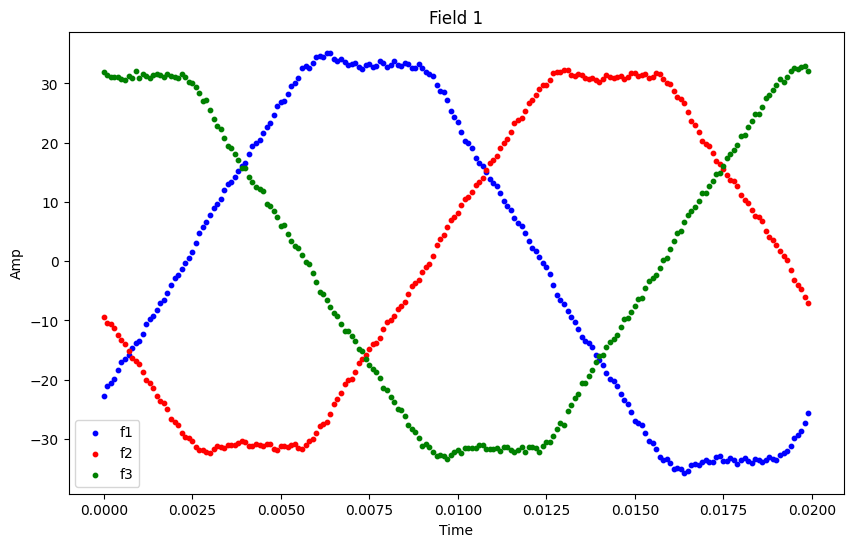

In [307]:
plt.figure(figsize=(10, 6))
plt.scatter(time[0:200], field_1_l1[0:200], label='f1', color='blue', s=10)
plt.scatter(time[0:200], field_1_l2[0:200], label='f2', color='red', s=10)
plt.scatter(time[0:200], field_1_l3[0:200], label='f3', color='green', s=10)

plt.title('Field 1')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.legend()

plt.show()

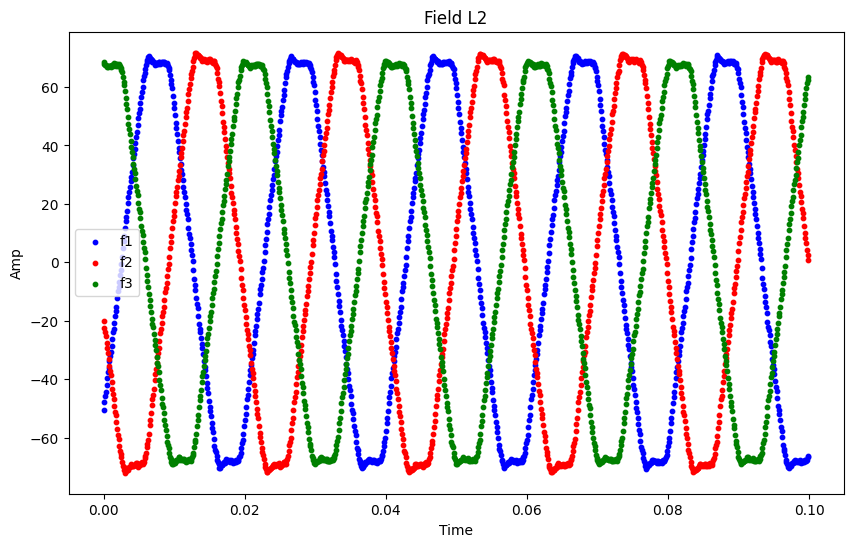

In [308]:
plt.figure(figsize=(10, 6))
plt.scatter(time[0:1000], field_2_l1[0:1000], label='f1', color='blue', s=10)
plt.scatter(time[0:1000], field_2_l2[0:1000], label='f2', color='red', s=10)
plt.scatter(time[0:1000], field_2_l3[0:1000], label='f3', color='green', s=10)

plt.title('Field L2')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.legend()

plt.show()

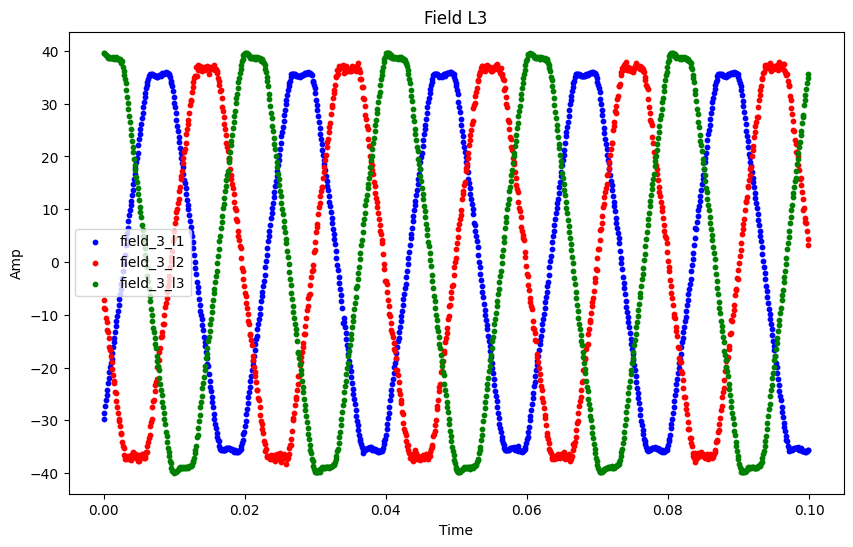

In [309]:
plt.figure(figsize=(10, 6))
plt.scatter(time[0:1000], field_3_l1[0:1000], label='field_3_l1', color='blue', s=10)
plt.scatter(time[0:1000], field_3_l2[0:1000], label='field_3_l2', color='red', s=10)
plt.scatter(time[0:1000], field_3_l3[0:1000], label='field_3_l3', color='green', s=10)

plt.title('Field L3')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.legend()

plt.show()

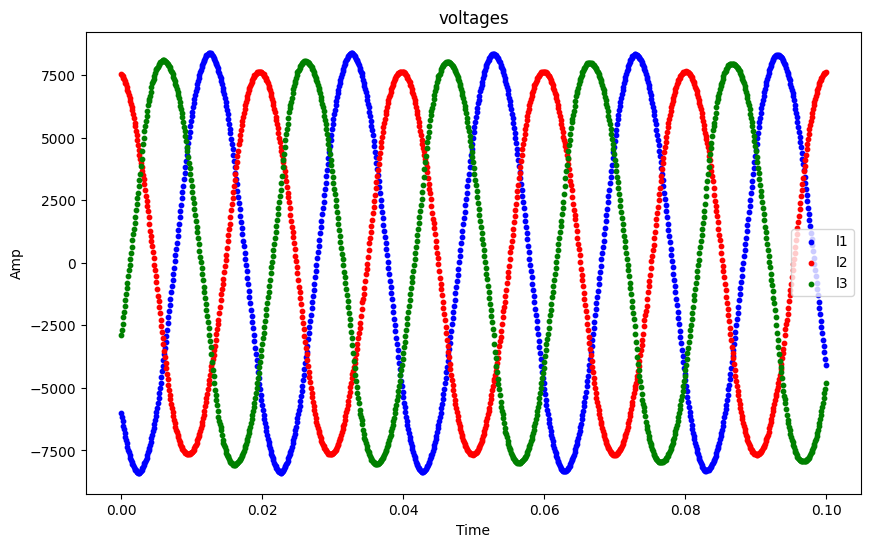

In [310]:
plt.figure(figsize=(10, 6))
plt.scatter(time[0:1000], l1_spanning[0:1000], label='l1', color='blue', s=10)
plt.scatter(time[0:1000], l2_spanning[0:1000], label='l2', color='red', s=10)
plt.scatter(time[0:1000], l3_spanning[0:1000], label='l3', color='green', s=10)

plt.title('voltages')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.legend()

plt.show()

In [311]:
def fft_initial_guess(time, values):
    t = np.array(time)
    N = len(t)
    y = np.array(values)
    window = windows.hann(N)
    y_windowed = y * window
    dt = (t[1]-t[0]) # assume uniform spacing
    measurement_freq = 1.0 / dt
    freq_resolution = measurement_freq / N
    
    freq = np.fft.fftfreq(N, dt)   
    positive_idx = np.where(freq >= 0)
    
    fft_result = np.fft.fft(y)
    positive_fft = fft_result[positive_idx]

    positive_freq = freq[positive_idx]
    
    peak_index = np.argmax(np.abs(positive_fft))
    dominant_freq = positive_freq[peak_index]
    
    dominant_fft = positive_fft[peak_index]
    phase_est = np.angle(dominant_fft)
    
    # Wrap phase to [-π, π]
    phase_est = np.mod(phase_est + np.pi, 2 * np.pi) - np.pi
    
    return phase_est, dominant_freq, dominant_freq - freq_resolution, dominant_freq + freq_resolution

# sin wave definition

In [312]:
def jacobian_sine_wave(x: np.ndarray, amplitude: float, frequency: float, phase: float, offset: float) -> np.ndarray:
    J = np.empty((x.size, 4))
    sin_term = np.sin(2 * np.pi * frequency * x + phase)
    cos_term = np.cos(2 * np.pi * frequency * x + phase)
    
    J[:, 0] = sin_term  # Derivative w.r.t amplitude
    J[:, 1] = amplitude * 2 * np.pi * x * cos_term  # Derivative w.r.t frequency
    J[:, 2] = amplitude * cos_term  # Derivative w.r.t phase
    J[:, 3] = 1  # Derivative w.r.t offset
    return J

def sine_wave(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

def fit_sin(time, values, initial_guess, bounds):
    def residuals(params):
        return sine_wave(time, *params) - values
    
    def jacobian(params):
        return jacobian_sine_wave(time, *params)
    
    params = least_squares(residuals, initial_guess, bounds=bounds, jac=jacobian, method="trf", loss="soft_l1").x # 'dogbox', 'lm',"trf"
    print(f"amp: {params[0].round(4)}, freq: {params[1].round(4)}, phase: {params[2].round(4)}({np.round(math.degrees(params[2].round(4)),4)}), offset: {params[3].round(4)}")
    return params

In [315]:
fitted_data_dict = {}
for name, values in data_dict.items():
    phase_est, freq_est, lower_freq, upper_freq = fft_initial_guess(time, values)
    guess_amp = np.std(values) * 2.**0.5
    # guess_amp2 = (np.max(values) - np.min(values)) / 2
    offset = np.mean(values)
    initial_guess = [guess_amp, freq_est, phase_est, offset]
    bounds = ([guess_amp-1, lower_freq, -np.pi, min(offset-1.0, -1.0)], [guess_amp+2, upper_freq, np.pi, min(offset+1.0, 1.0)])
    print(f"{name}, initial guess: {initial_guess}")
    
    fitted_data_dict[name] = fit_sin(time, values, initial_guess, bounds)
    
    
for name, values in spanning_data_dict.items():
    phase_est, freq, lower_freq, upper_freq = fft_initial_guess(time, values)
    guess_amp = np.std(values) * 2.**0.5
    offset = np.mean(values)
    initial_guess = [guess_amp, freq, phase_est, offset]
    bounds = ([guess_amp-20, lower_freq, -np.pi, min(offset-5.0, -5.0)], [guess_amp+20, upper_freq, np.pi, max(offset+5.0, 5.0)])
    print(f"{name}, initial guess: {initial_guess}")

    fitted_data_dict[name] = fit_sin(time, values, initial_guess, bounds)

field_1_l1, initial guess: [np.float64(35.41141872170756), np.float64(49.5), np.float64(-0.8527094792889143), np.float64(-0.05572929441447493)]
amp: 35.2157, freq: 49.6118, phase: -0.6897(-39.5169), offset: -0.0928
field_2_l1, initial guess: [np.float64(71.79624056941314), np.float64(49.5), np.float64(-0.918583452251037), np.float64(0.15267219753582506)]
amp: 71.3061, freq: 49.6118, phase: -0.7556(-43.2927), offset: 0.0886
field_3_l1, initial guess: [np.float64(37.34197683120373), np.float64(49.5), np.float64(-1.0231210662367958), np.float64(0.001526260160849955)]
amp: 37.2092, freq: 49.6117, phase: -0.8607(-49.3145), offset: -0.0296
field_1_l2, initial guess: [np.float64(32.837168211165135), np.float64(49.5), np.float64(-2.994019810285424), np.float64(-0.006891630840925035)]
amp: 32.6539, freq: 49.6117, phase: -2.83(-162.1471), offset: 0.0424
field_2_l2, initial guess: [np.float64(73.13344335635898), np.float64(49.5), np.float64(-3.011291189375348), np.float64(-0.19181747383277498)]
a

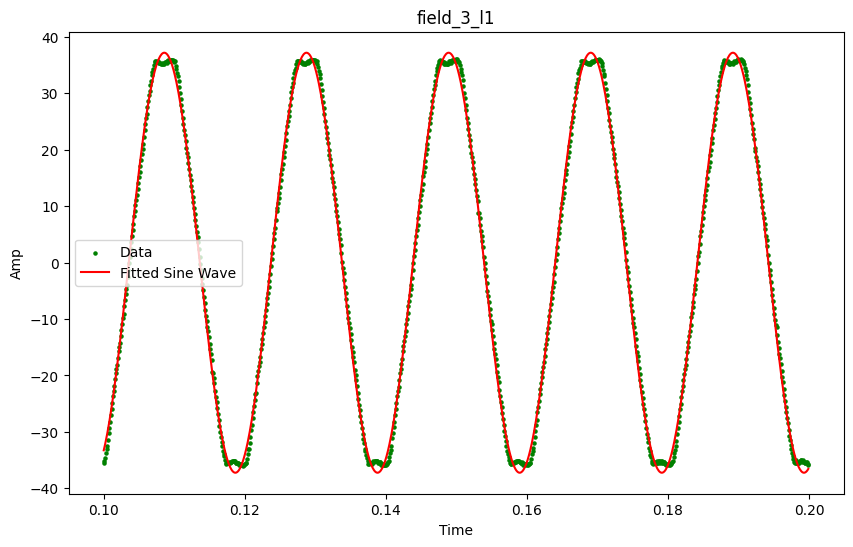

In [316]:
plt.figure(figsize=(10, 6))

n = 1000
name = "field_3_l1"

t = time[n:(n+1000)] 
plt.scatter(t, data_dict[name][n:(n+1000)], label='Data', color='green', s=5)
plt.plot(t, sine_wave(t, *fitted_data_dict[name]), label='Fitted Sine Wave', color='red')

plt.title(name)
plt.xlabel('Time')
plt.ylabel('Amp')
plt.legend()
plt.show()

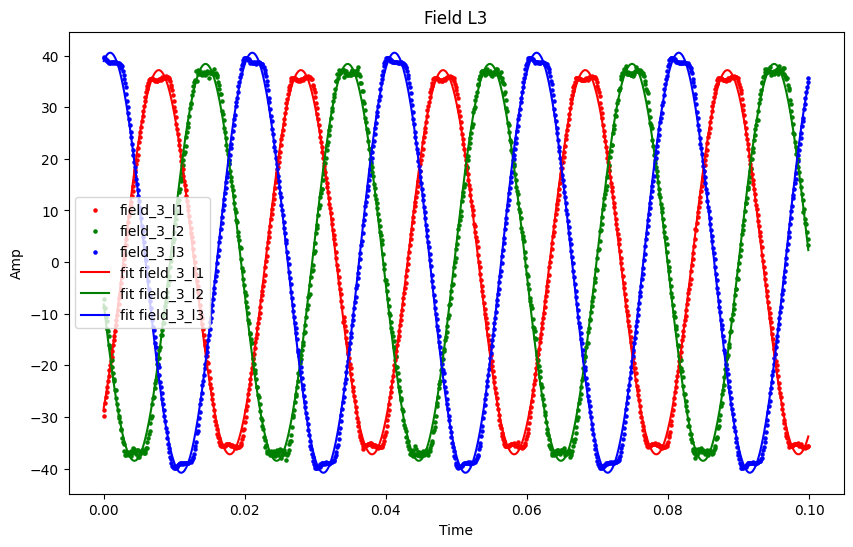

In [317]:
plt.figure(figsize=(10, 6))

n = 0
name1 = "field_3_l1"
name2 = "field_3_l2"
name3 = "field_3_l3"

t = time[n:(n+1000)] 
plt.scatter(t, data_dict[name1][n:(n+1000)], label=name1, color='red', s=5)
plt.scatter(t, data_dict[name2][n:(n+1000)], label=name2, color='green', s=5)
plt.scatter(t, data_dict[name3][n:(n+1000)], label=name3, color='blue', s=5)

plt.plot(t, sine_wave(t, *fitted_data_dict[name1]), label=f"fit {name1}", color='red')
plt.plot(t, sine_wave(t, *fitted_data_dict[name2]), label=f"fit {name2}", color='green')
plt.plot(t, sine_wave(t, *fitted_data_dict[name3]), label=f"fit {name3}", color='blue')

plt.title('Field L3')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.legend()

plt.show()

40000


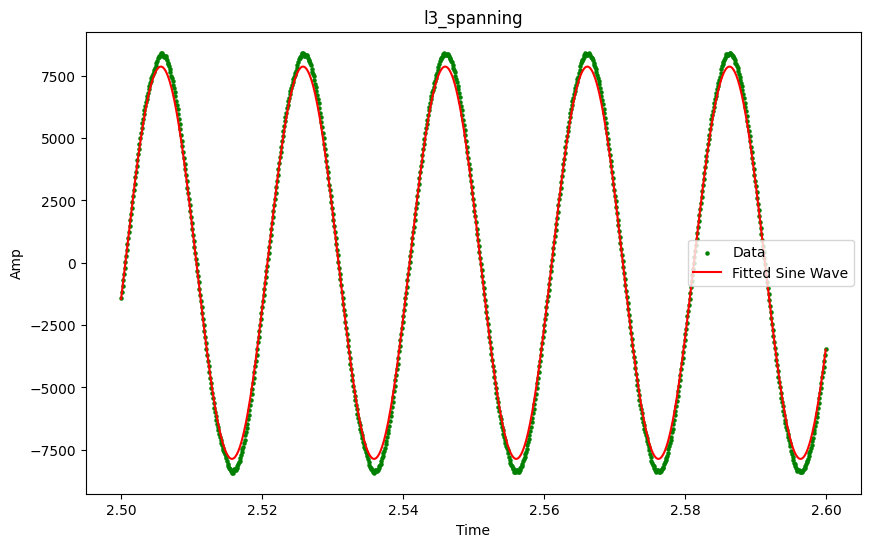

In [318]:
plt.figure(figsize=(10, 6))

print(len(time))

n = 25000
name = "l3_spanning"

t = time[n:(n+1000)] 
plt.scatter(t, spanning_data_dict[name][n:(n+1000)], label='Data', color='green', s=5)
plt.plot(t, sine_wave(t, *fitted_data_dict[name]), label='Fitted Sine Wave', color='red')

plt.title(name)
plt.xlabel('Time')
plt.ylabel('Amp')
plt.legend()

plt.show()

In [325]:
def print_phase_diffs(f1, f2, f3, s1):
    f1_phase = math.degrees(f1[2])
    f2_phase = math.degrees(f2[2])
    f3_phase = math.degrees(f3[2])
    s1_phase = math.degrees(s1[2])
    
    print("phase of voltage field 1: {:0.3f}".format(s1_phase))
    print("phase difference field 1: {:0.3f}".format(s1_phase-f1_phase))
    print("phase difference field 2: {:0.3f}".format(s1_phase-f2_phase))
    print("phase difference field 3: {:0.3f}".format(s1_phase-f3_phase))
    

In [321]:
print("phase differences phase L1")
print_phase_diffs(fitted_data_dict["field_1_l1"], fitted_data_dict["field_2_l1"], fitted_data_dict["field_3_l1"], fitted_data_dict["l1_spanning"])
print("phase differences phase L2")
print_phase_diffs(fitted_data_dict["field_1_l2"], fitted_data_dict["field_2_l2"], fitted_data_dict["field_3_l2"], fitted_data_dict["l2_spanning"])
print("phase differences phase L3")
print_phase_diffs(fitted_data_dict["field_1_l3"], fitted_data_dict["field_2_l3"], fitted_data_dict["field_3_l3"], fitted_data_dict["l3_spanning"])


phase differences phase L1
phase of voltage field 1: -134.752
phase difference field 1: -95.235
phase difference field 2: -91.457
phase difference field 3: -85.437
phase differences phase L2
phase of voltage field 1: 101.561
phase difference field 1: 263.708
phase difference field 2: 264.715
phase difference field 3: 269.330
phase differences phase L3
phase of voltage field 1: -21.620
phase difference field 1: -101.230
phase difference field 2: -97.178
phase difference field 3: -95.419
